In [6]:
suppressMessages({library("rwwa"); library(quantreg)})

In [20]:
gmst <- read.table("data/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2026]

In [23]:
df <- read.csv("data/ts_pr_era5x.csv")
df$year <- as.integer(substr(df$time,1,4))
df$month <- as.integer(substr(df$time,6,7))
df <- merge(gmst, df)

df <- df[df$time <= "2026-02-09",] # ERA5 forecast is very high, had huge leverage in model

In [ ]:
rx1day <- merge(gmst, read.csv("data/rx1day_era5.csv"))
rx1day_djf <- merge(gmst, read.csv("data/rx1day-djf_era5.csv"))
rx3day <- merge(gmst, read.csv("data/rx3day_era5.csv"))
rx3day_djf <- merge(gmst, read.csv("data/rx3day-djf_era5.csv"))

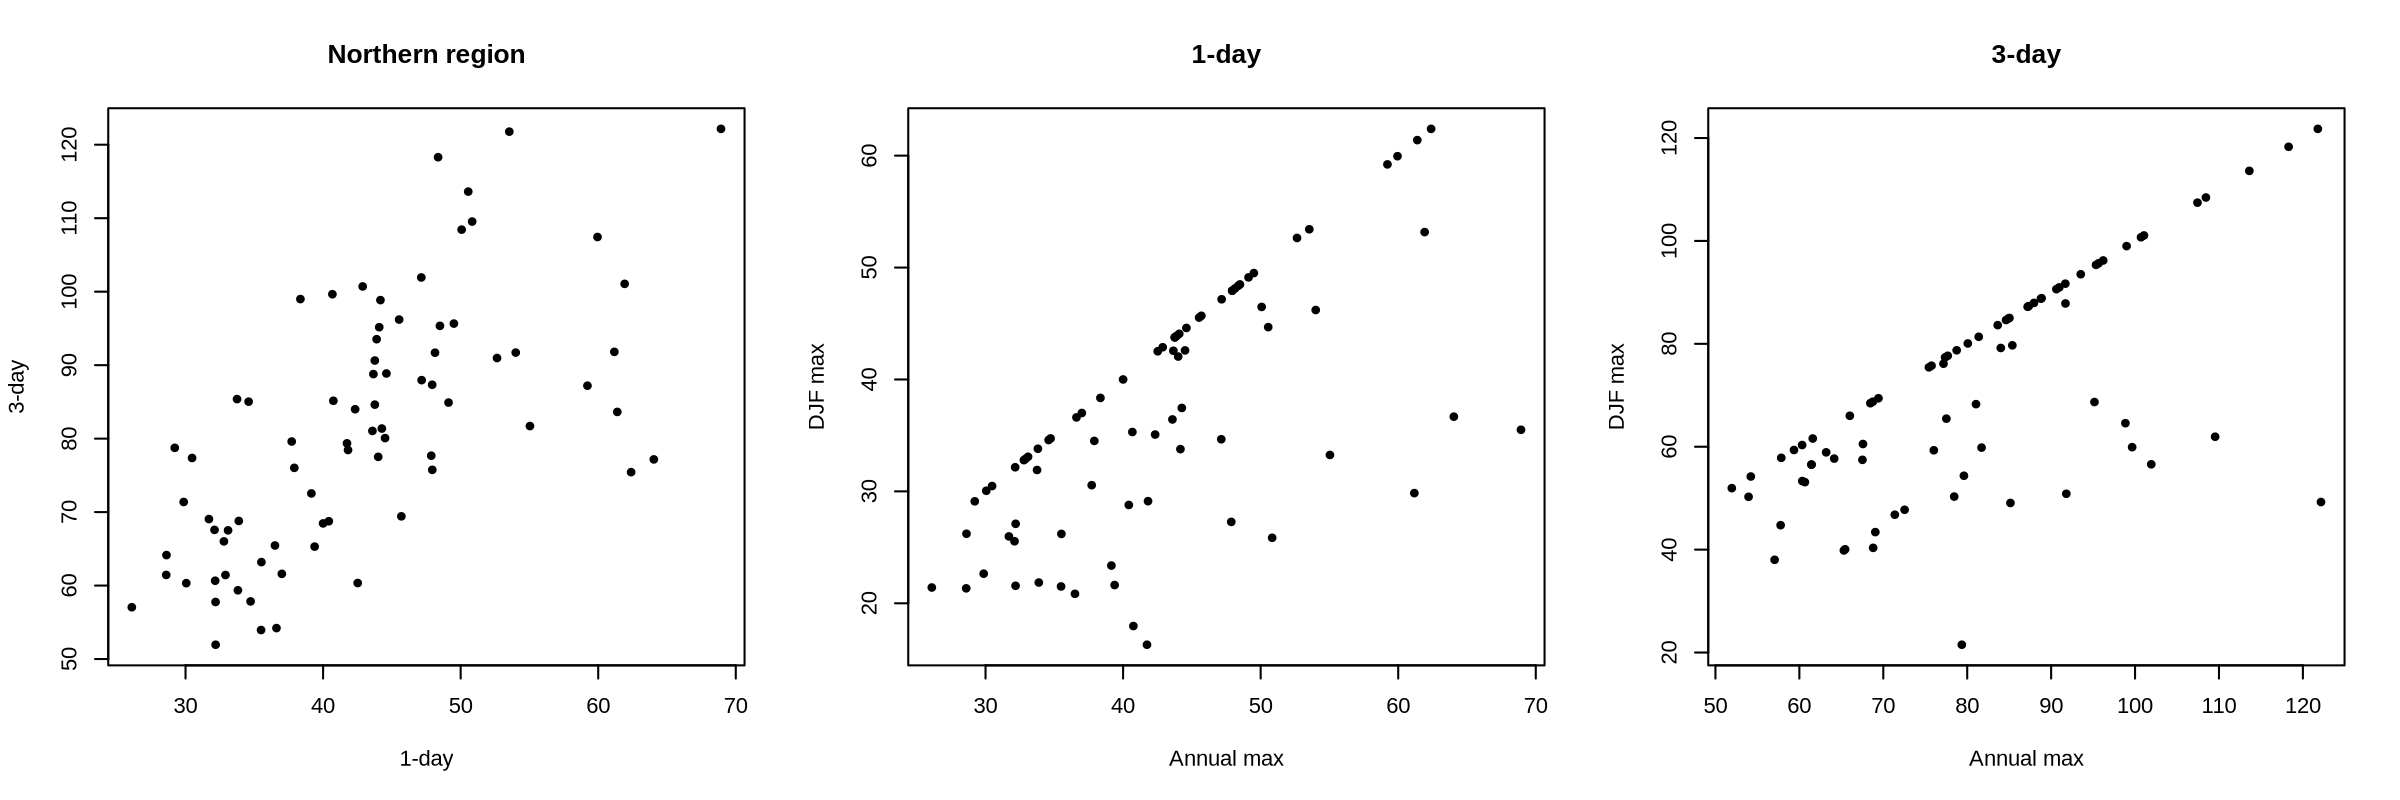

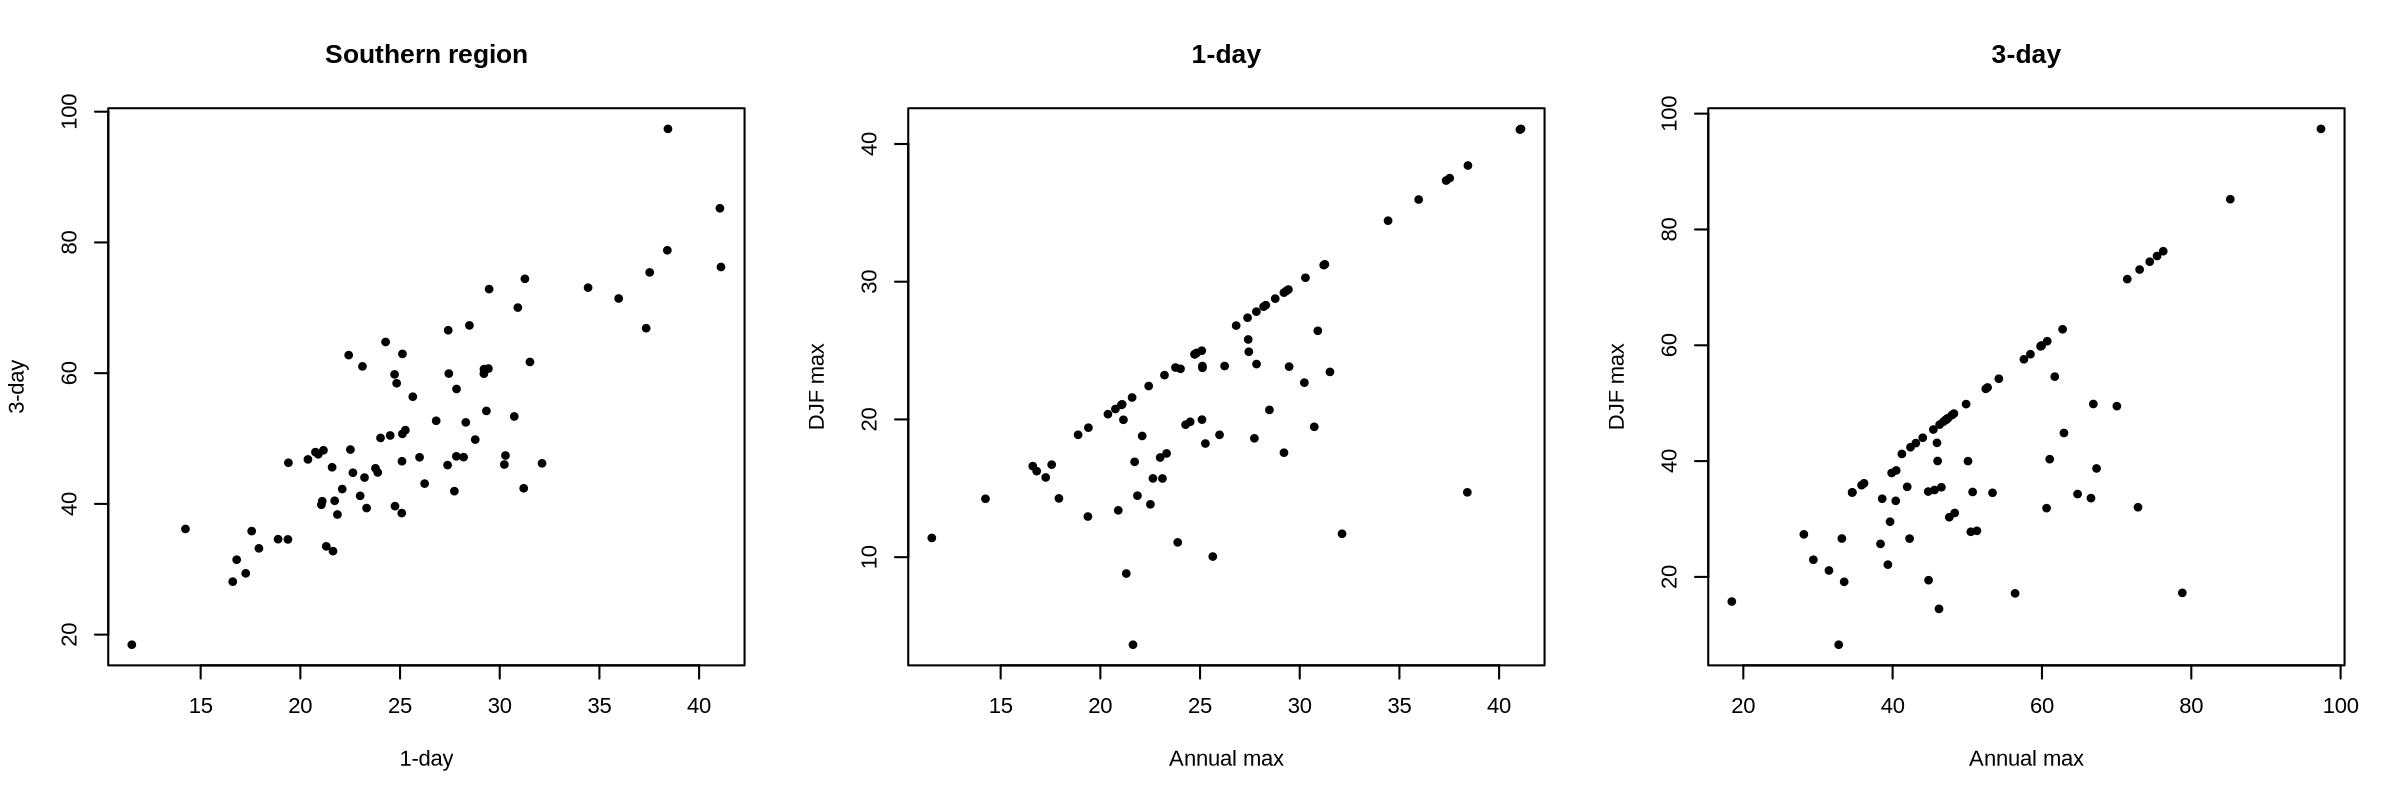

In [52]:
prep_window(c(1,3))

plot(rx1day$pr_n, rx3day$pr_n, xlab = "1-day", ylab = "3-day", main = "Northern region")
plot(rx1day$pr_n, rx1day_djf$pr_n, xlab = "Annual max", ylab = "DJF max", main = "1-day")
plot(rx3day$pr_n, rx3day_djf$pr_n, xlab = "Annual max", ylab = "DJF max", main = "3-day")

plot(rx1day$pr_s, rx3day$pr_s, xlab = "1-day", ylab = "3-day", main = "Southern region")
plot(rx1day$pr_s, rx1day_djf$pr_s, xlab = "Annual max", ylab = "DJF max", main = "1-day")
plot(rx3day$pr_s, rx3day_djf$pr_s, xlab = "Annual max", ylab = "DJF max", main = "3-day")


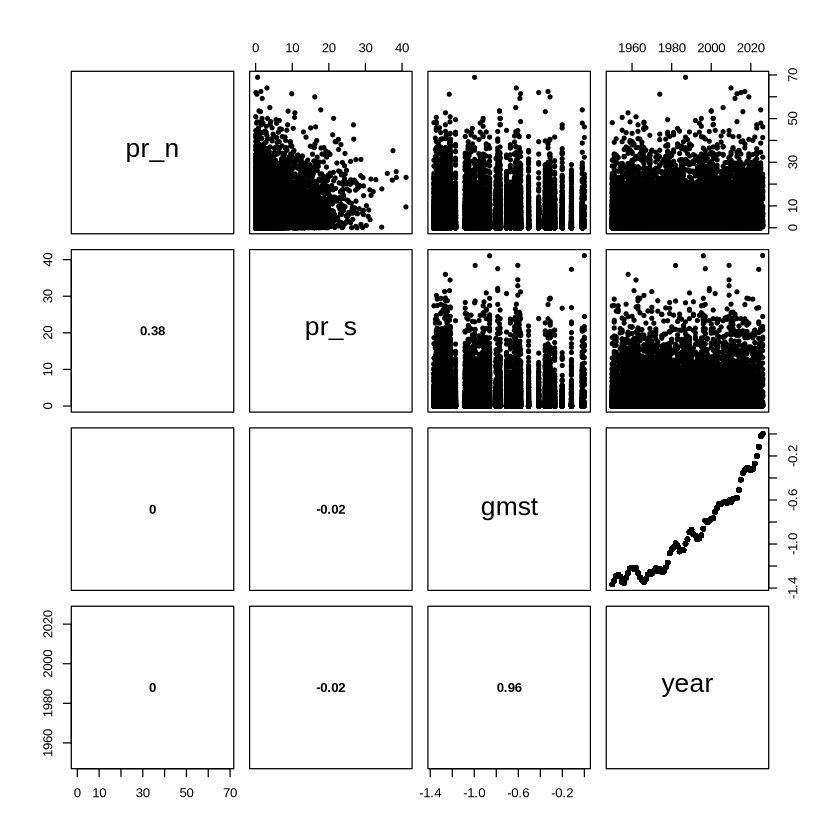

In [36]:
prep_window(res = 120, h = 7, w = 7)

pairs(df[,c("pr_n", "pr_s", "gmst", "year")], lower.panel = panel.cor)

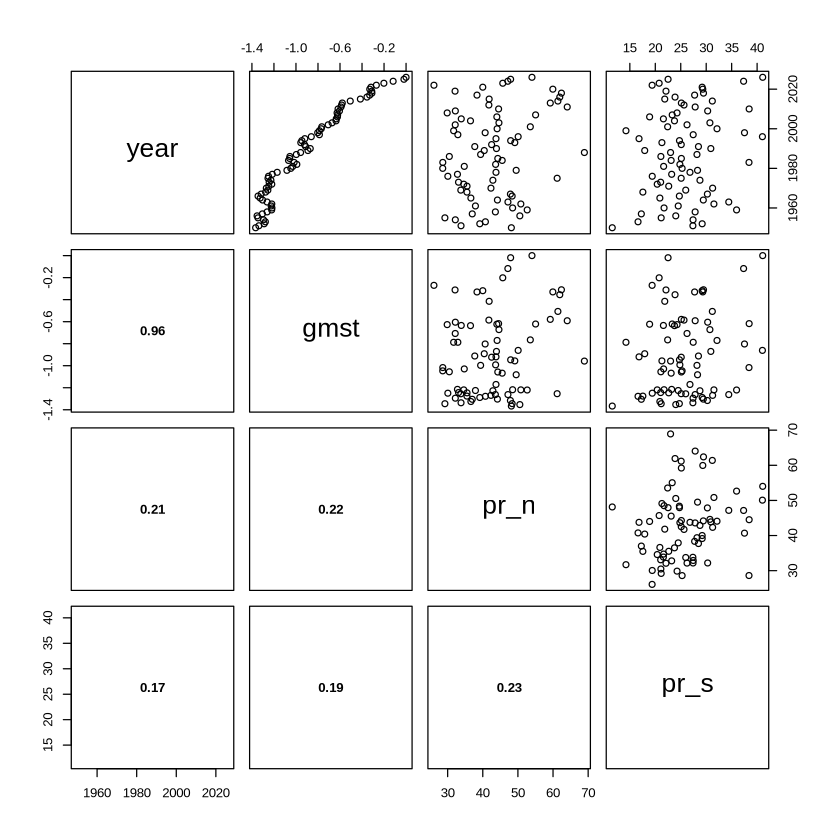

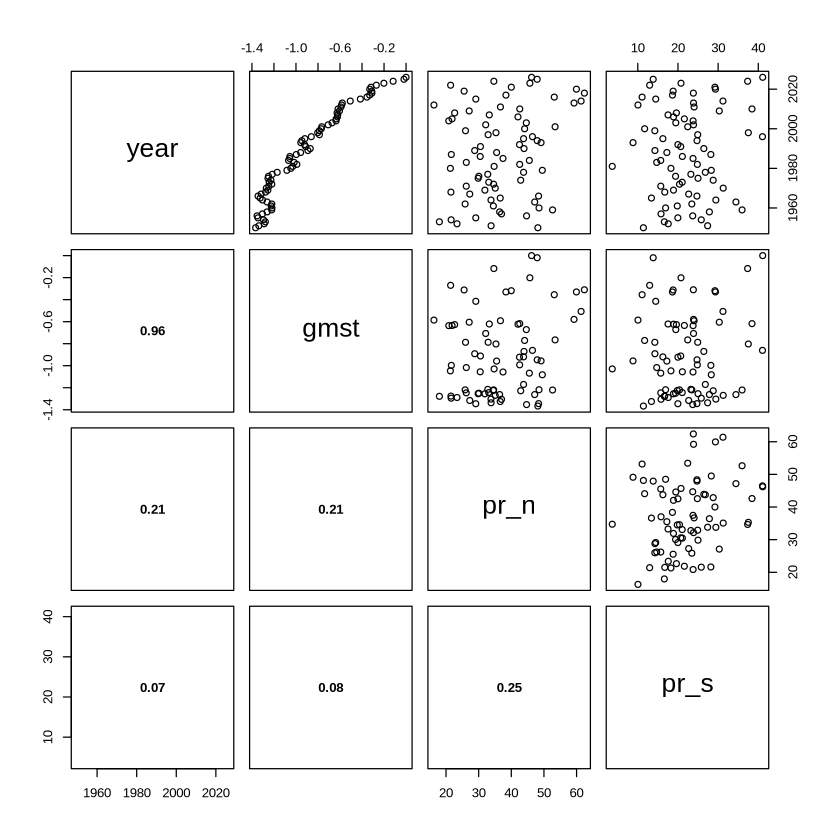

In [41]:
pairs(rx1day, lower.panel = panel.cor)
pairs(rx1day_djf, lower.panel = panel.cor)

# quick GEV fit

In [ ]:
fitted <- fit_ns("gev", "fixeddisp", data = rx1day, varnm = "pr_n", covnm = "gmst")

cov_2026 <- gmst[gmst$year == 2026,"gmst",drop = F]
cov_cf <- data.frame("pi" = cov_2026 - 1.3)

In [59]:
fitted_n <- sapply(list("rx1day" = rx1day, "rx1day (DJF)" = rx1day_djf, "rx3day" = rx3day, "rx3day (DJF)" = rx3day_djf), 
                   function(rx) fit_ns("gev", "fixeddisp", data = rx, varnm = "pr_n", covnm = "gmst"), simplify = F)

fitted_s <- sapply(list("rx1day" = rx1day, "rx1day (DJF)" = rx1day_djf, "rx3day" = rx3day, "rx3day (DJF)" = rx3day_djf), 
                   function(rx) fit_ns("gev", "fixeddisp", data = rx, varnm = "pr_s", covnm = "gmst"), simplify = F)

In [163]:
signif(t(sapply(list("Northern" = fitted_n[["rx1day (DJF)"]], "Southern" = fitted_s[["rx1day (DJF)"]]), mdl_ests, cov_f = cov_2026, cov_cf = cov_cf)), 3)

,mu0,sigma0,alpha_gmst,shape,disp,event_magnitude,return_period,PR,dI_abs,dI_rel,aic
Northern,40.1,12.60,8.18,-0.325,0.314,46.2,2.24,4.48,10.80,30.3,586
Southern,21.3,7.81,2.32,-0.211,0.367,41.1,38.10,8.36,5.42,15.2,534


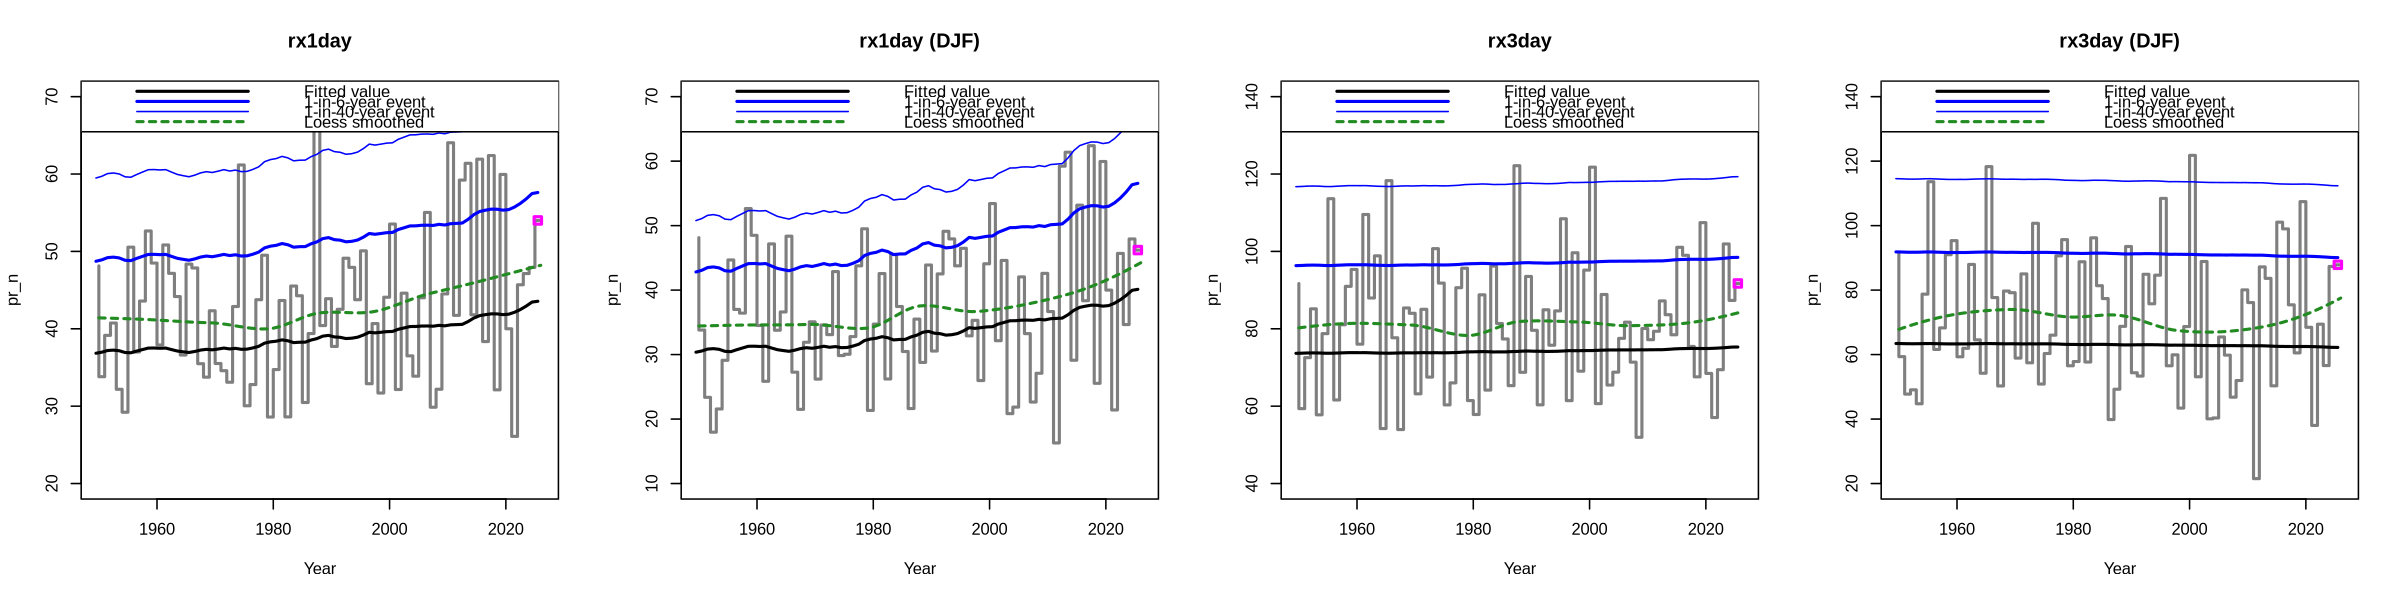

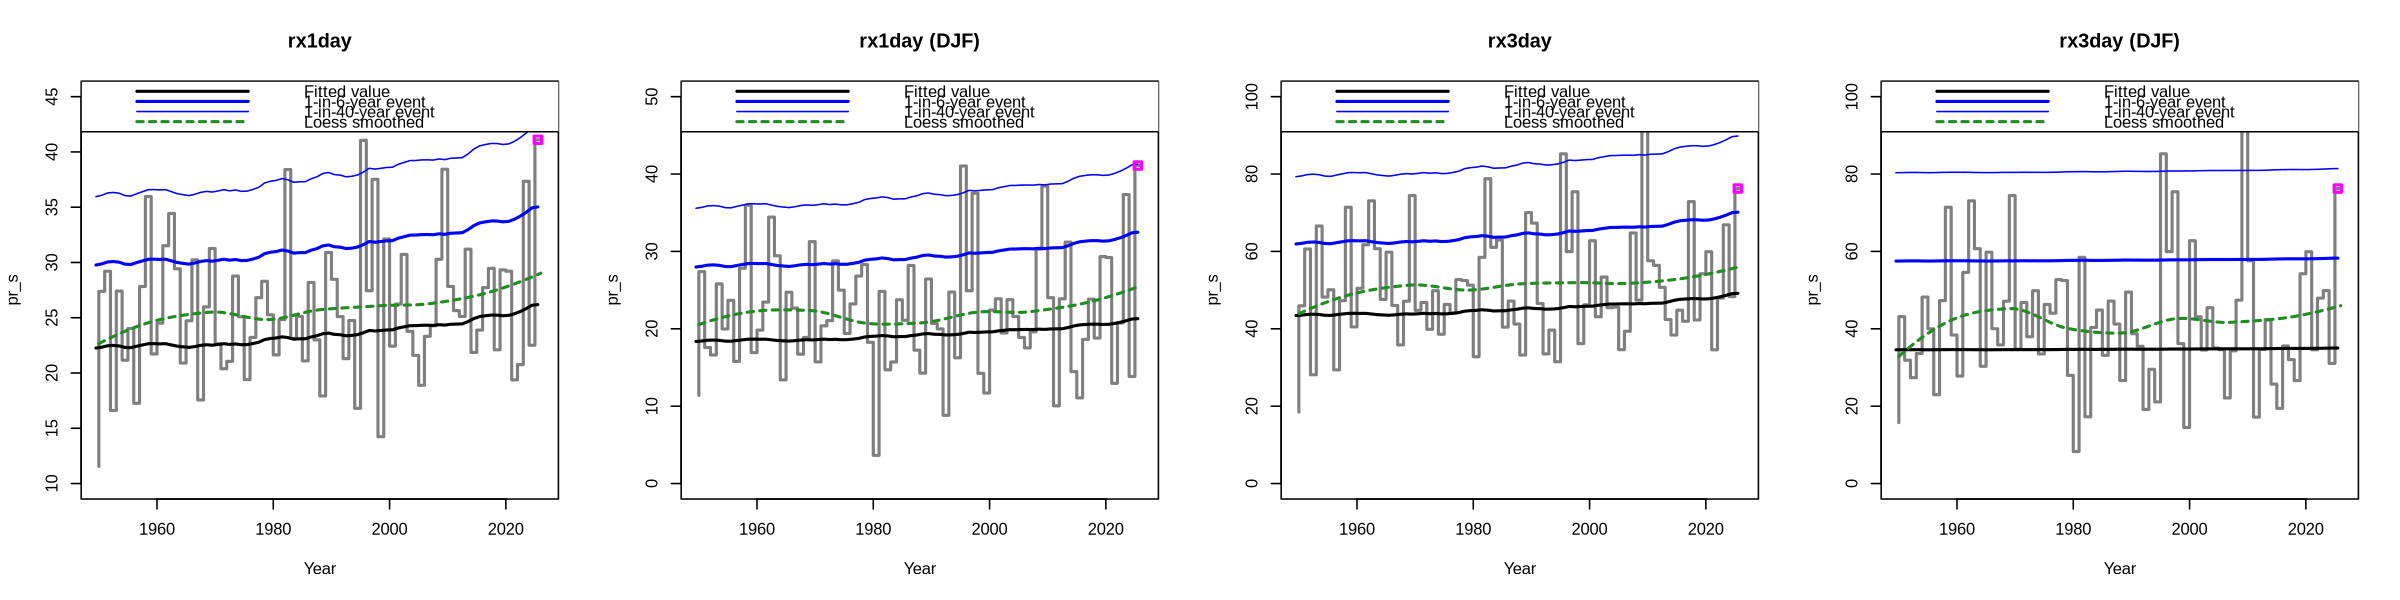

In [149]:
prep_window(c(1,4), res = 150)

for (i in 1:4) {
    plot_trend(fitted_n[[i]], main = names(fitted_n)[i])
}

for (i in 1:4) {
    plot_trend(fitted_s[[i]], main = names(fitted_s)[i])
}

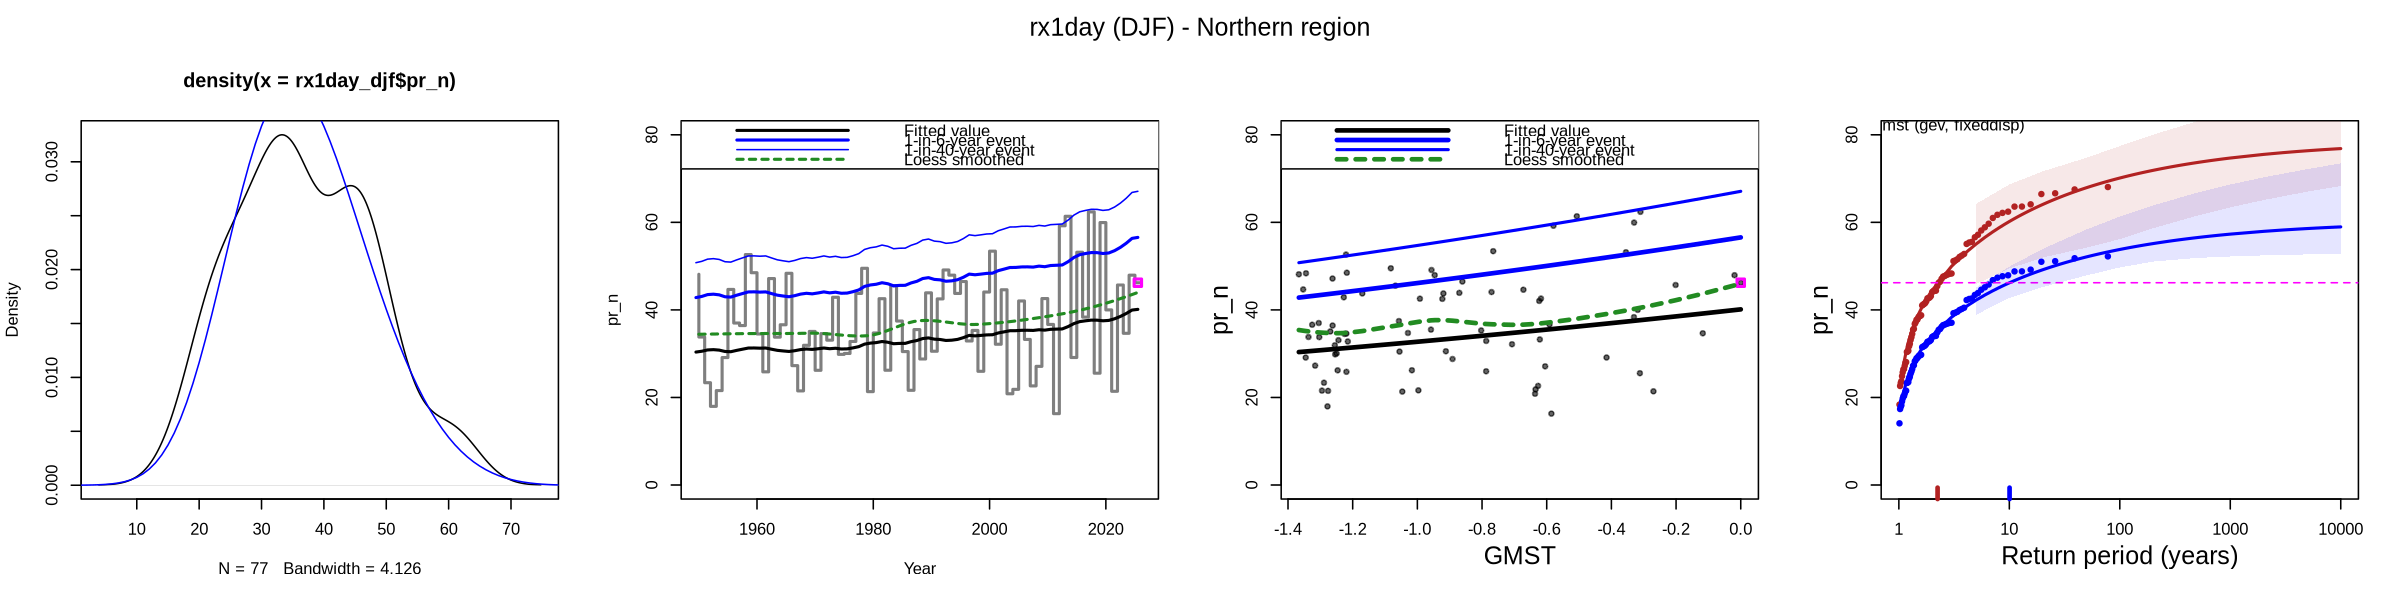

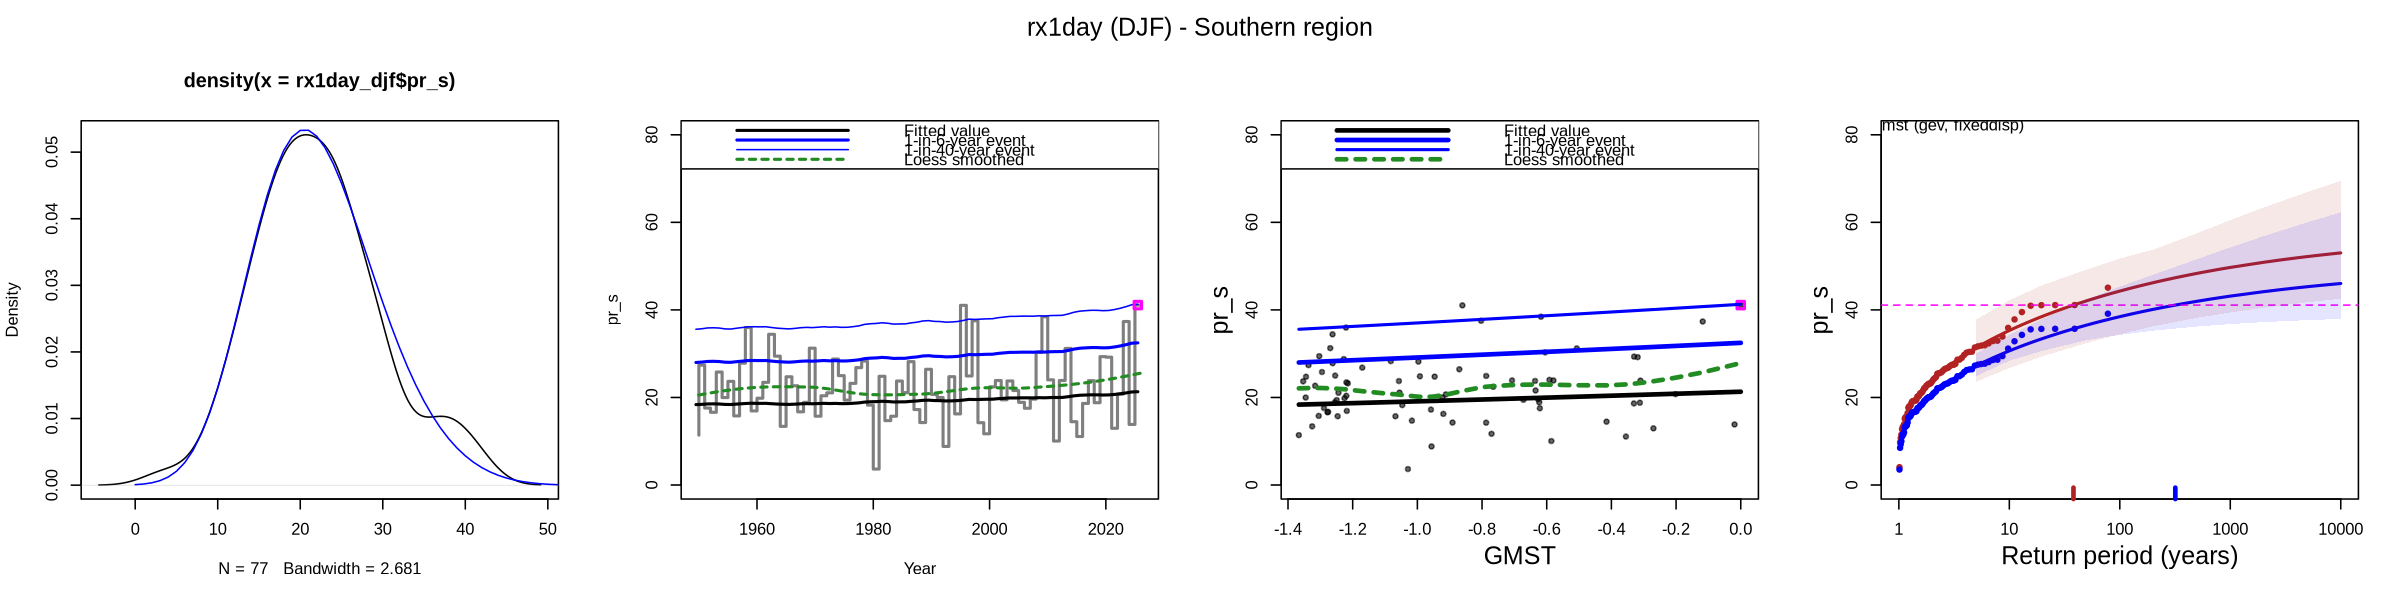

In [159]:
# Quick check that GEV is appropriate for rx1day_djf
prep_window(c(1,4), res = 150, oma = c(0,0,2,0))

plot(density(rx1day_djf$pr_n))
lines(x <- seq(0,80), do.call(devd, append(setNames(as.list(fevd(rx1day_djf$pr_n, rx1day_djf)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue")
plot_trend(fitted_n[["rx1day (DJF)"]], main = "", ylim = c(0,80))
plot_covtrend(fitted_n[["rx1day (DJF)"]], "gmst", main = "", ylim = c(0,80))
plot_returnlevels(fitted_n[["rx1day (DJF)"]], cov_f = cov_2026, cov_cf = cov_cf, nsamp = 50, ylim = c(0,80))
mtext("rx1day (DJF) - Northern region", side = 3, outer = T)

plot(density(rx1day_djf$pr_s))
lines(x <- seq(0,80), do.call(devd, append(setNames(as.list(fevd(rx1day_djf$pr_s, rx1day_djf)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue")
plot_trend(fitted_s[["rx1day (DJF)"]], main = "", ylim = c(0,80))
plot_covtrend(fitted_s[["rx1day (DJF)"]], "gmst", main = "", ylim = c(0,80))
plot_returnlevels(fitted_s[["rx1day (DJF)"]], cov_f = cov_2026, cov_cf = cov_cf, nsamp = 50, ylim = c(0,80))
mtext("rx1day (DJF) - Southern region", side = 3, outer = T)

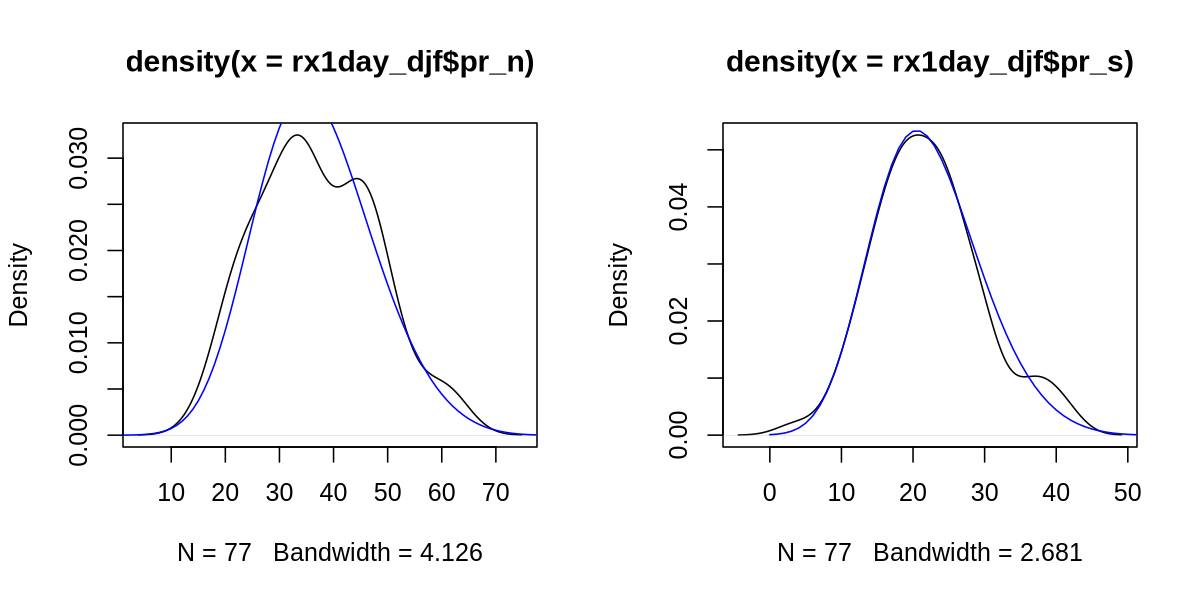

In [69]:
plot(density(rx1day_djf$pr_s))
lines(x <- seq(0,60), do.call(devd, append(setNames(as.list(fevd(rx1day_djf$pr_s, rx1day_djf)$results$par), c("loc", "scale", "shape")), list(x = x))), col = "blue")

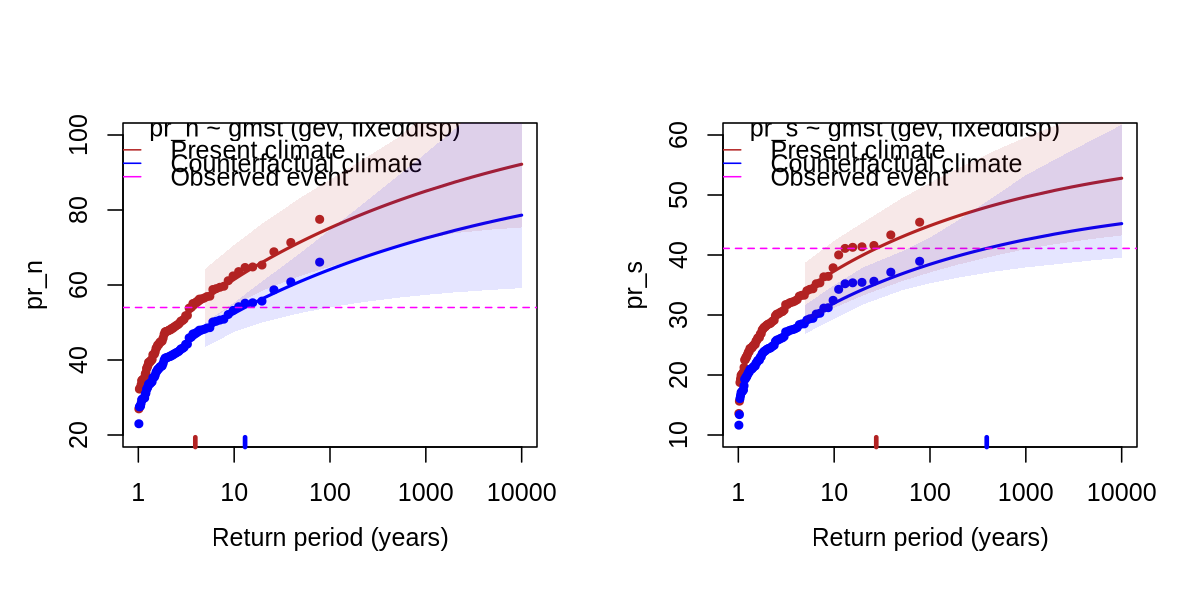

In [70]:
prep_window(c(1,2), res = 150)

plot_returnlevels(fitted_n[["rx1day"]], cov_f = cov_2026, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(fitted_s[["rx1day"]], cov_f = cov_2026, cov_cf = cov_cf, nsamp = 50)

# Peaks over thresholds

In [338]:
djf <- df[df$month %in% c(12,1,2),]
pr <- "pr_s"
rnm = paste0(c("pr_n" = "Northern", "pr_s" = "Southern")[pr], " region")

## Sensitivity to threshold

In [339]:
qq <- quantile(djf[(djf$year >= 1990) & (djf$year <= 2020), pr], c(0.95, .99, .995, .99725, .9975, .999))
qq

95%      99%    99.5%  99.725%   99.75%    99.9% 
11.10032 21.06669 24.02618 29.36200 29.43917 35.09349

Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(zu):
“NaNs produced”
Warning message in log(zu):
“NaNs produced”
Warning message in log(zu):
“NaNs produced”


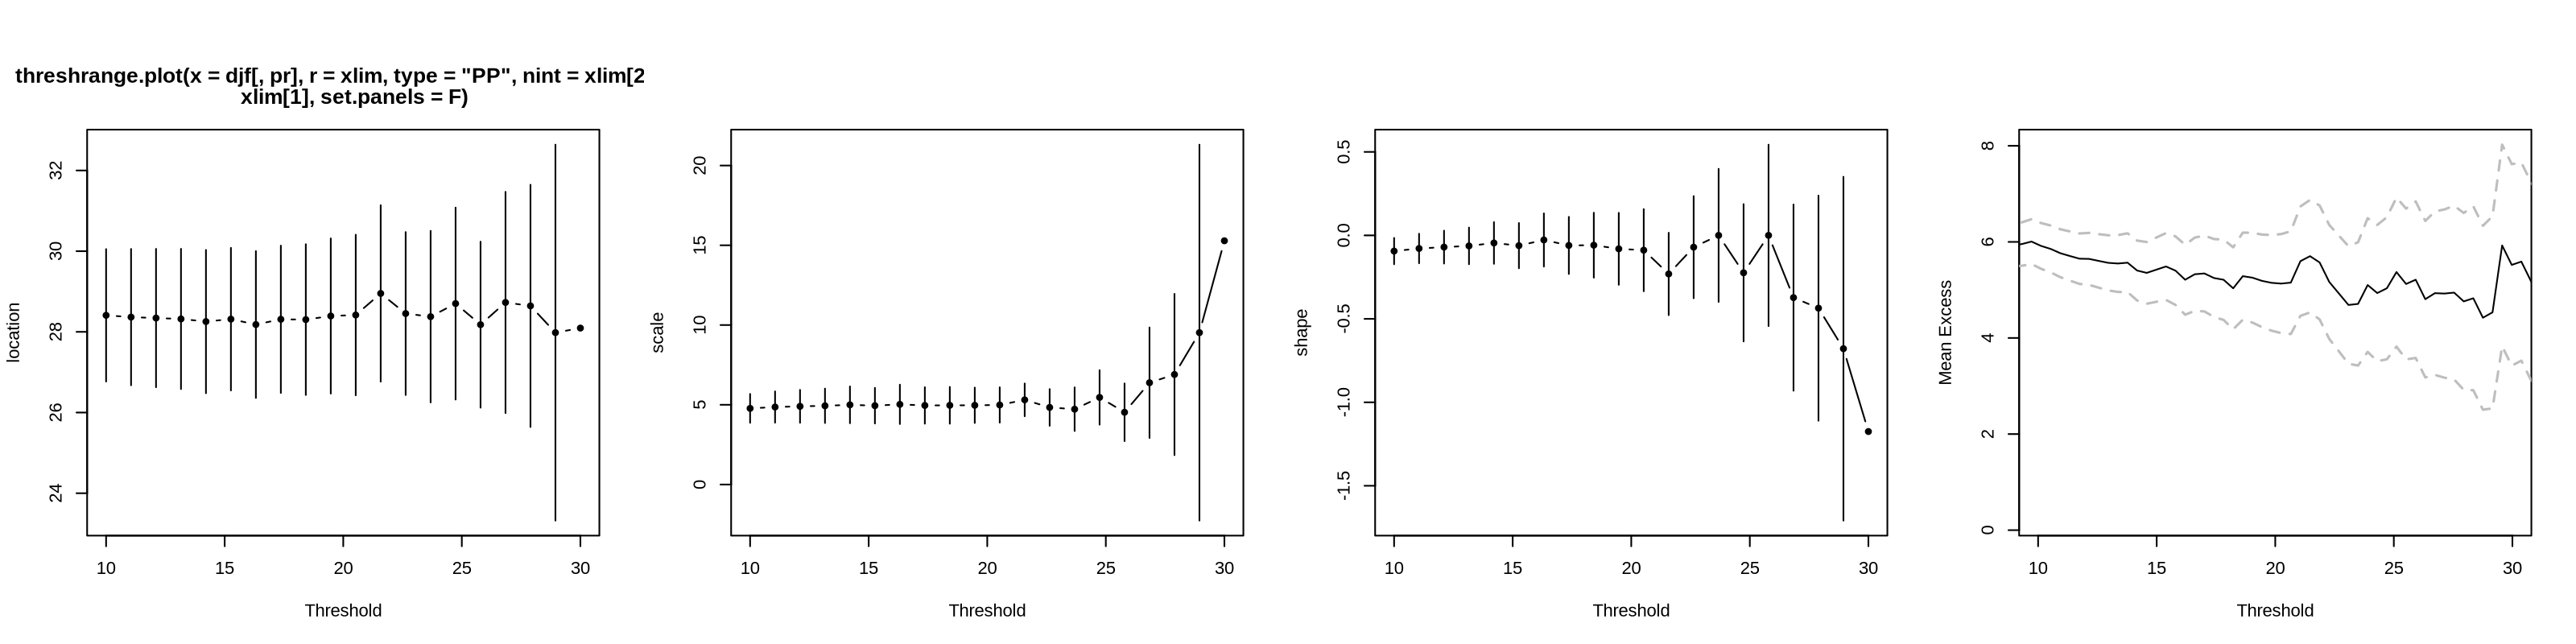

In [340]:
prep_window(c(1,4), oma = c(0,0,2,0))

xlim = c(10,ceiling(qq["99.75%"]/10)*10)

threshrange.plot(djf[,pr], r = xlim, nint = xlim[2]-xlim[1], set.panels = F, type = "PP")
mrlplot(djf[,pr], xlim = xlim)

# anywhere from 30-40 looks like a reasonable choice: 99-99.5%

## Trends in exceedances

In [382]:
# get abs values of extremes
df_x <- djf[djf[,pr] >= qq["99%"],]

# decluster using built-in method
df_dc <- decluster(djf[,pr], threshold = qq["99%"], r = 1)

In [311]:
n_peryear <- aggregate(djf[,pr] >= qq["99%"], by = list("year" = djf$year), FUN = "sum", simplify = T)
n_perymonth <- aggregate(djf[,pr] >= qq["99%"], by = list(djf$month, djf$year), FUN = "sum", simplify = T)
n_permonth <- aggregate(n_perymonth[,"x",drop = F], by = list("cmonth" = n_perymonth$Group.1), FUN = "mean")
n_permonth$m_offset <- ((n_permonth$cmonth + 4) %% 12) + 1 # adjust months to cut at start of August (driest part of year)

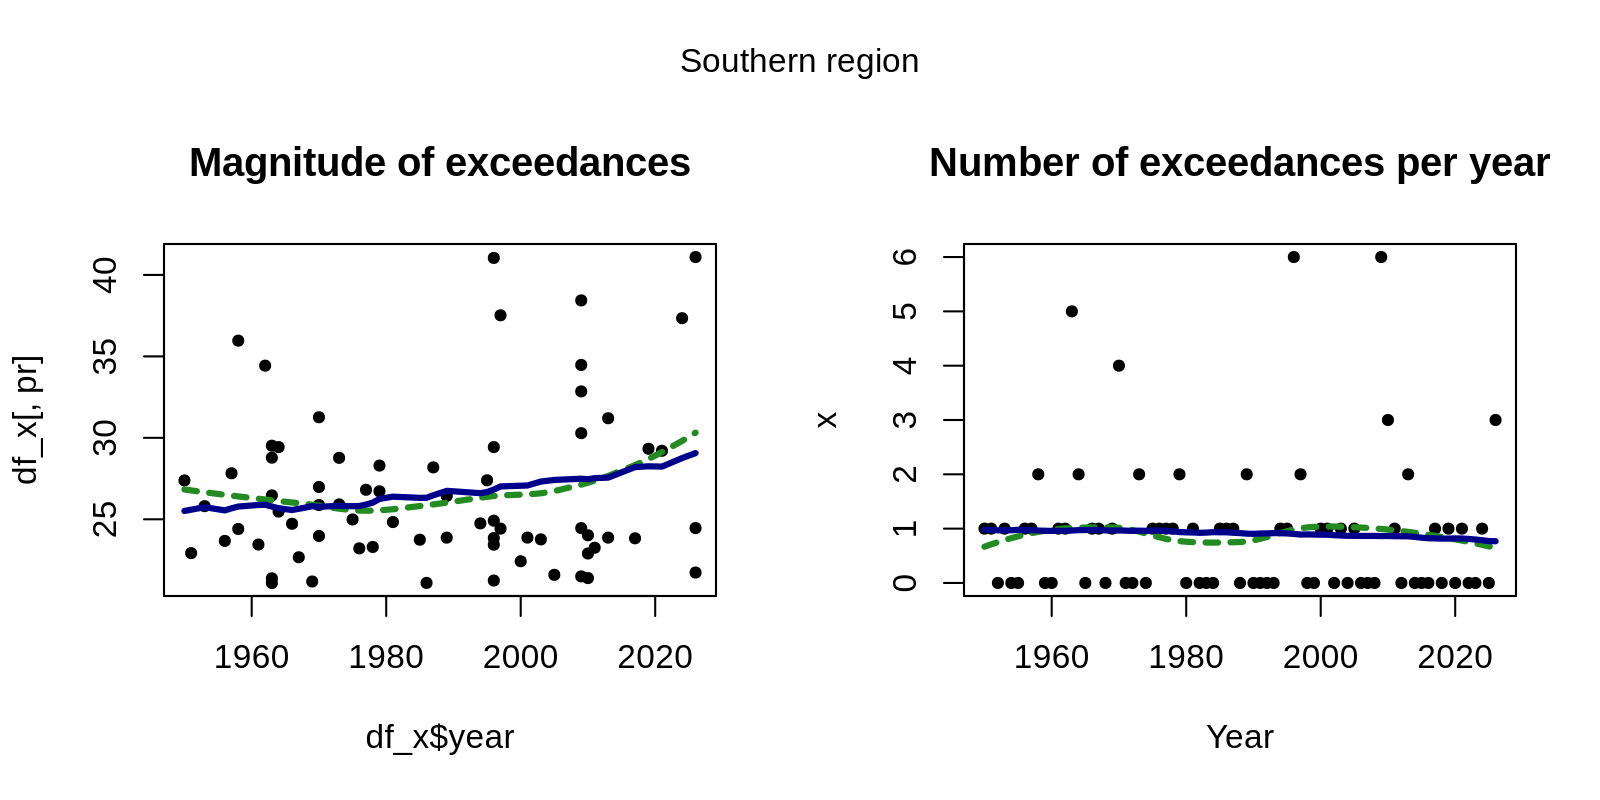

In [312]:
prep_window(c(1,2), oma = c(0,0,2,0))

plot(df_x$year, df_x[,pr], main = "Magnitude of exceedances")
lines(df_x$year, fitted(loess(paste0(pr," ~ year"), df_x)), col = "forestgreen", lty = "22", lwd = 3) # add a smoother through magnitude of exceedances
lines(df_x$year, fitted(lm(paste0(pr," ~ gmst"), df_x)), lwd = 3, col = "darkblue")


plot(n_peryear, main = "Number of exceedances per year", xlab = "Year")
lines(n_peryear$year, fitted(loess(x ~ year, n_peryear)), col = "forestgreen", lty = "22", lwd = 3) # add a smoother through number of exceedances
lines(n_peryear$year, fitted(lm(x ~ gmst, merge(gmst, n_peryear))), lwd = 3, col = "darkblue")

mtext(rnm, outer = T, side = 3)

# plot(n_permonth$cmonth, n_permonth$x, main = "Mean exceedances per calendar month", xlim = c(1,12), xlab = "Calendar month", type = "o")

## Point process model

In [461]:
mdl_pp_shift <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), threshold = qq["99%"], location.fun = ~gmst, type = "PP")
mdl_pp_scale <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), threshold = qq["99%"], scale.fun = ~gmst, type = "PP")
mdl_pp_shiftscale <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), threshold = qq["99%"], location.fun = ~gmst, scale.fun = ~gmst, type = "PP")

mdl_pp <- mdl_pp_scale

In [462]:
aic_pp <- invisible(sapply(list("Shift" = mdl_pp_shift, "Scale" = mdl_pp_scale, "Shift + scale" = mdl_pp_shiftscale),
       function(mdl) summary(mdl)$AIC))


fevd(x = df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), 
    threshold = qq["99%"], location.fun = ~gmst, type = "PP")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  152.1764 


 Estimated parameters:
        mu0         mu1       scale       shape 
28.23076577  0.06554192  5.57747363 -0.22154781 

 Standard Error Estimates:
      mu0       mu1     scale     shape 
3.1045097 2.8436319 0.5833383 0.1593814 

 Estimated parameter covariance matrix.
             mu0        mu1        scale        shape
mu0    9.6379805  8.1657928  0.129064643 -0.333046887
mu1    8.1657928  8.0862422 -0.165313726 -0.251769928
scale  0.1290646 -0.1653137  0.340283592  0.000517826
shape -0.3330469 -0.2517699  0.000517826  0.025402440

 AIC = 312.3527 

 BIC = 320.5945 

fevd(x = df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), 
    threshold = qq["99%"], scale.fun = ~gmst, type = "PP")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  150.5

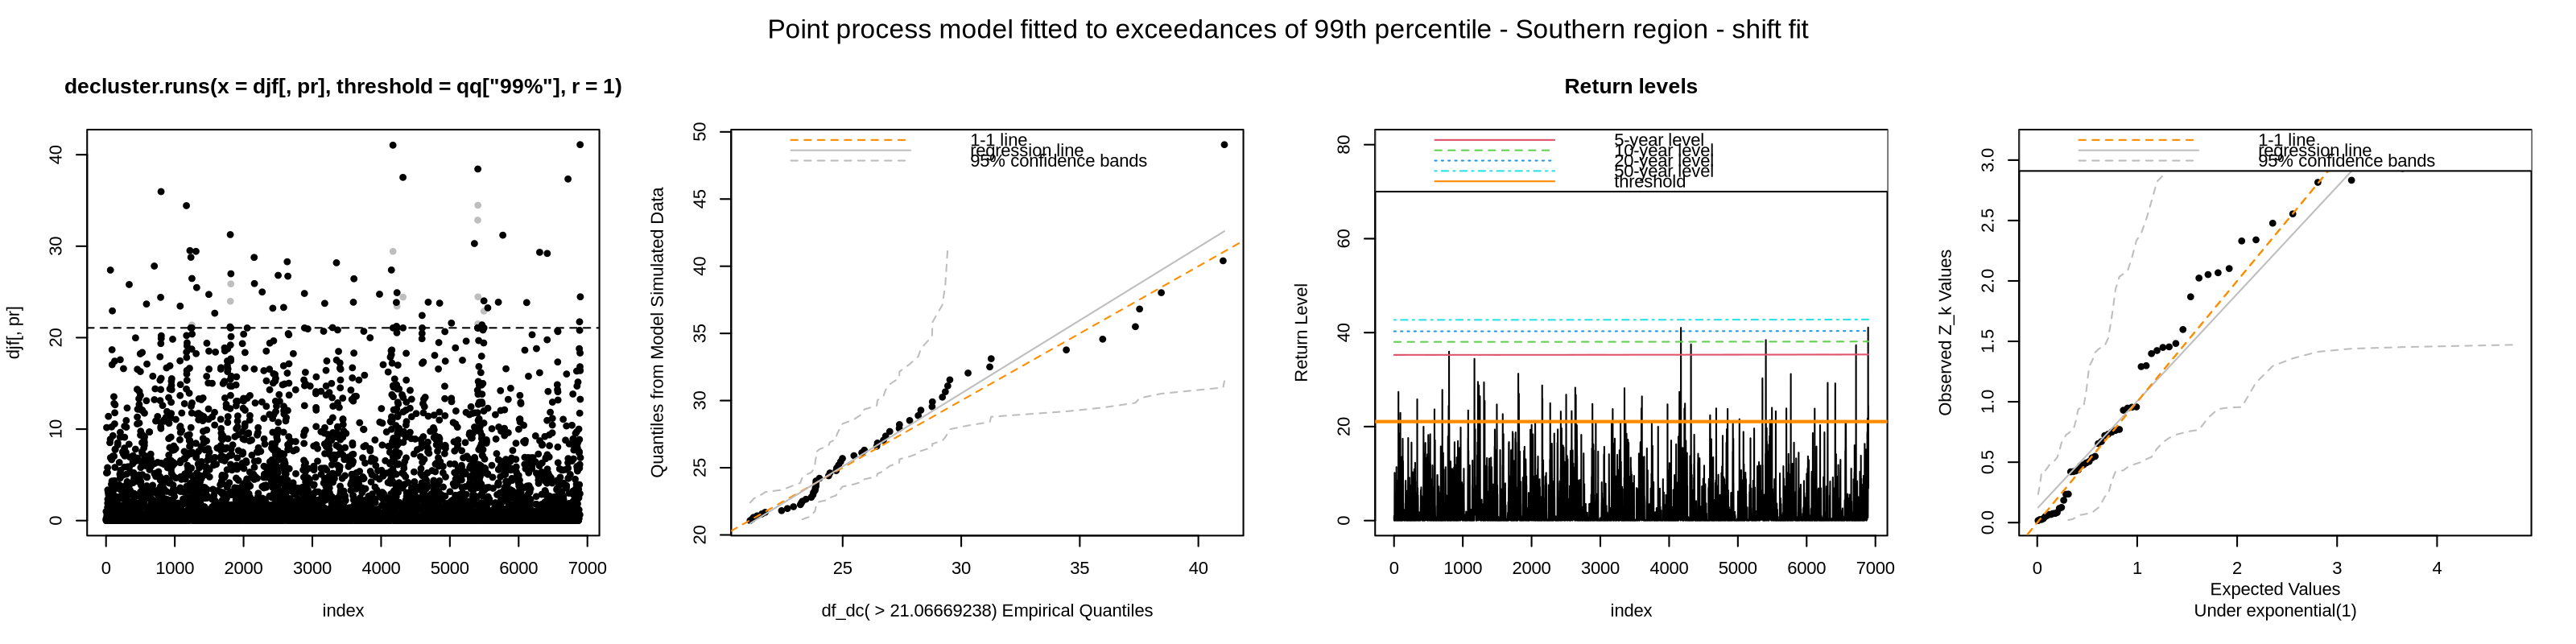

In [493]:
prep_window(c(1,4), oma = c(0,0,2,0))
plot(df_dc)                        # very little declustering needed - 1-day captures the maxima fairly well
plot(mdl_pp_shift, type = "qq2", ylim = c(0,80), xlim = c(0,80))
plot(mdl_pp_shift, type = "rl", rperiods = c(5, 10, 20, 50), main = "Return levels", ylim = c(0,80))
plot(mdl_pp_shift, type = "Zplot")
mtext(paste0("Point process model fitted to exceedances of 99th percentile - ",rnm, " - shift fit"), side = 3, outer = T)

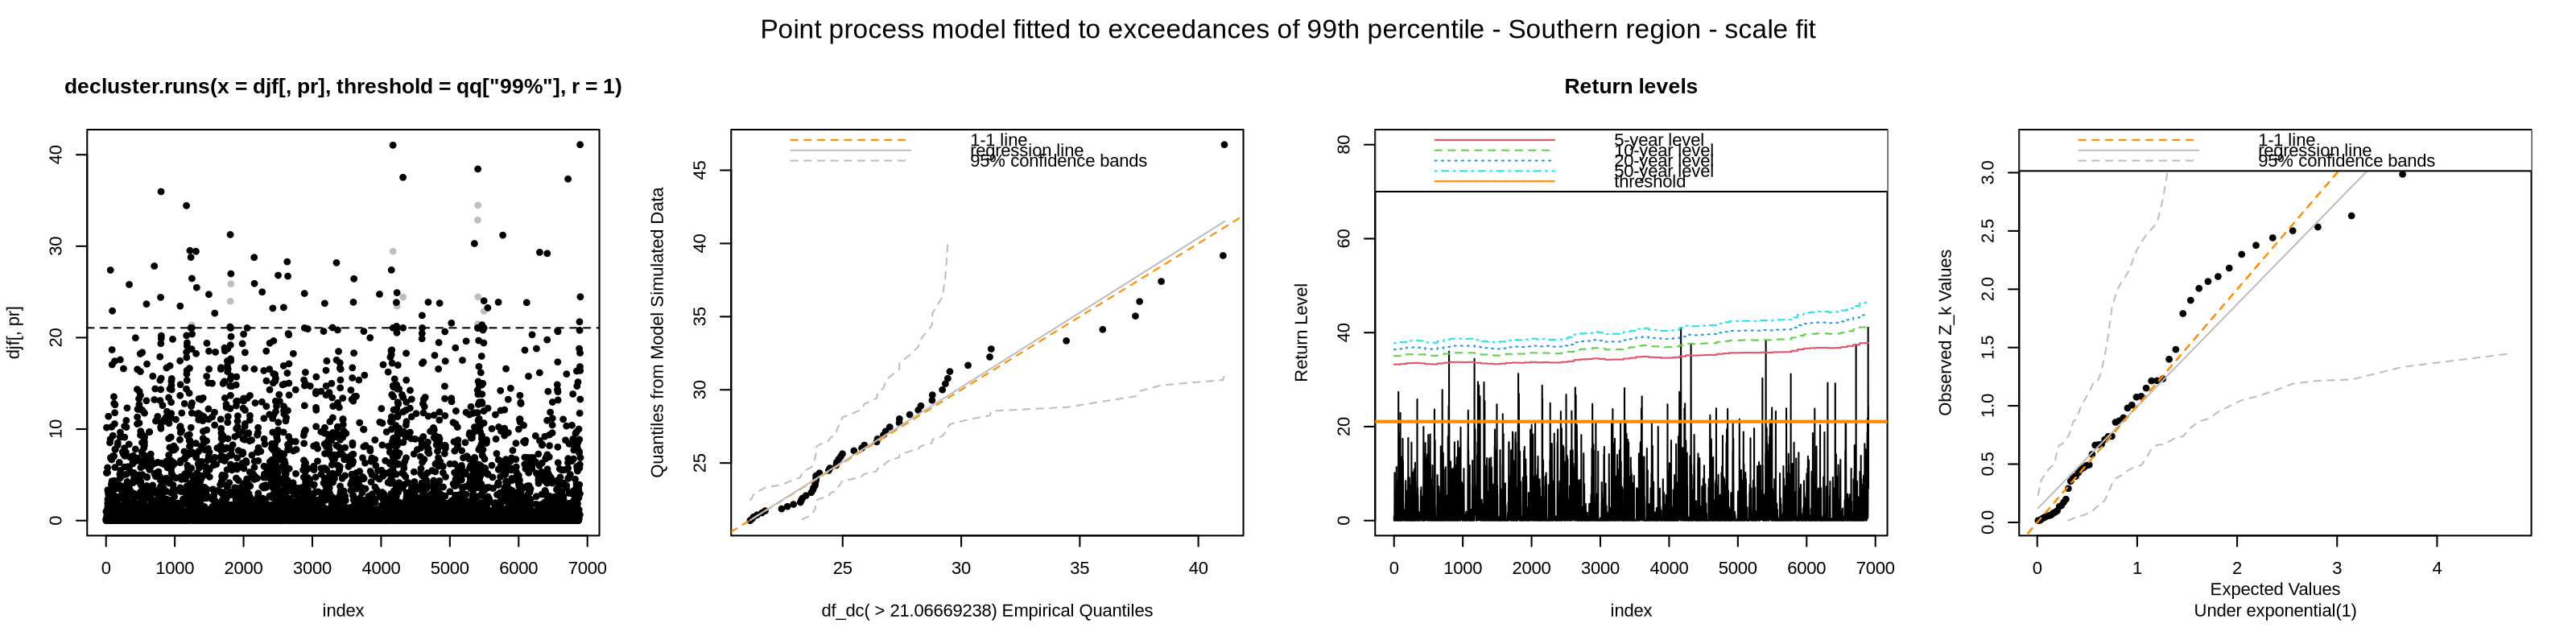

In [495]:
prep_window(c(1,4), oma = c(0,0,2,0))
plot(df_dc)                        # very little declustering needed - 1-day captures the maxima fairly well
plot(mdl_pp_scale, type = "qq2", ylim = c(0,80), xlim = c(0,80))
plot(mdl_pp_scale, type = "rl", rperiods = c(5, 10, 20, 50), main = "Return levels", ylim = c(0,80))
plot(mdl_pp_scale, type = "Zplot")
mtext(paste0("Point process model fitted to exceedances of 99th percentile - ",rnm, " - scale fit"), side = 3, outer = T)

### Compare fitted models

In [478]:
prep_window(c(1,1))

pars_shift <- setNames(as.list(mdl_pp_shift$results$par), c("loc", "alpha", "scale", "shape"))

In [479]:
pars_shift <- setNames(as.list(mdl_pp_shift$results$par), c("loc", "alpha", "scale", "shape"))
pars_scale <- setNames(as.list(mdl_pp_scale$results$par), c("loc", "scale", "beta", "shape"))
pars_shiftscale <- setNames(as.list(mdl_pp_shiftscale$results$par), c("loc", "alpha", "scale", "beta", "shape"))

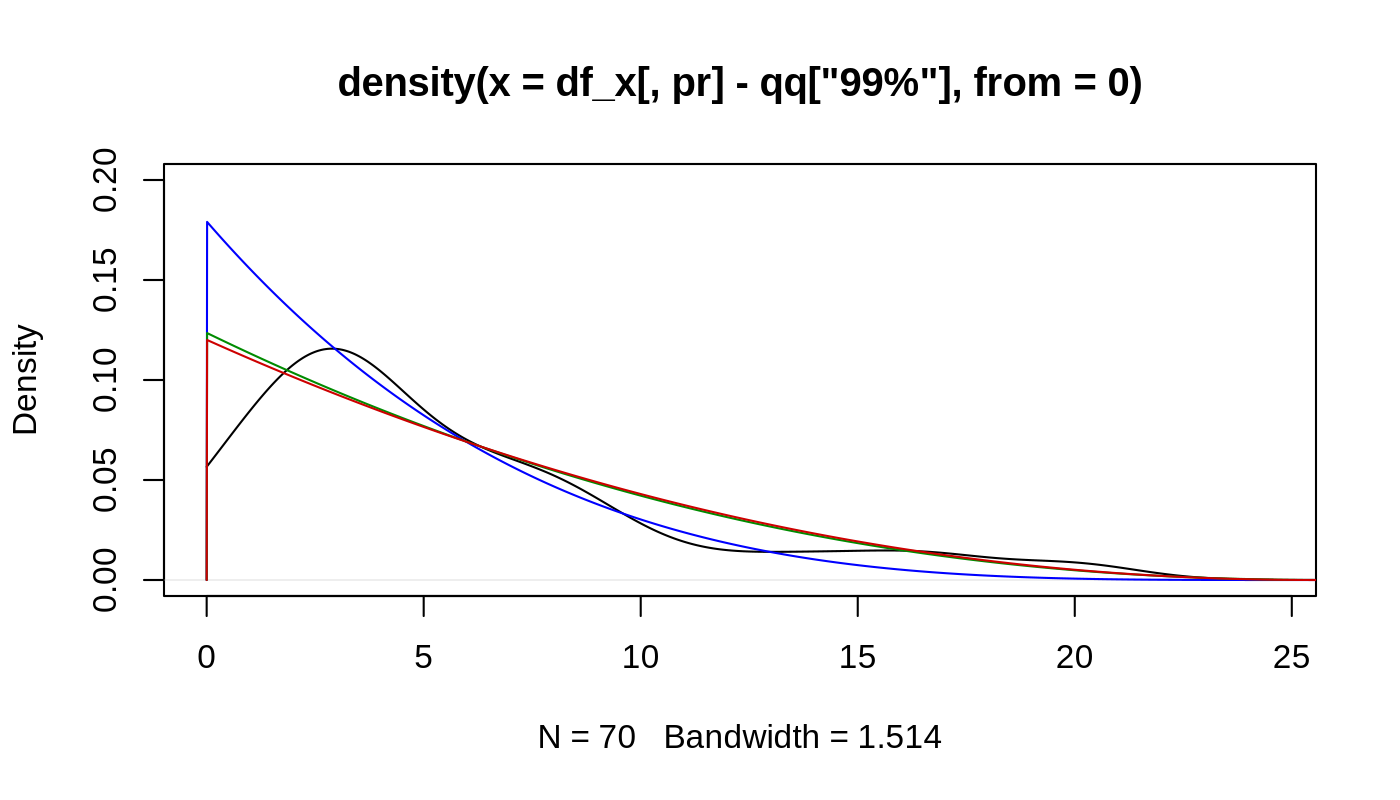

In [523]:
prep_window(w = 7)
plot(density(df_x[,pr] - qq["99%"], from = 0), ylim = c(0,0.2))
lines(x <- seq(0,40,0.01), do.call(devd, append(as.list(sapply(c("scale", "shape"), function(v) pars_shift[[v]])), 
                                                 list(x = x, type = "GP"))), col = "blue")
lines(x <- seq(0,40,0.01), do.call(devd, append(as.list(sapply(c("scale", "shape"), function(v) pars_scale[[v]])), 
                                                 list(x = x, type = "GP"))), col = "green4")
lines(x <- seq(0,40,0.01), do.call(devd, append(as.list(sapply(c("scale", "shape"), function(v) pars_shiftscale[[v]])), 
                                                 list(x = x, type = "GP"))), col = "red3")

## Generalised Pareto

In [497]:
mdl_gpd <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = djf$gmst), threshold = qq["99%"], scale.fun = ~gmst, type = "GP")

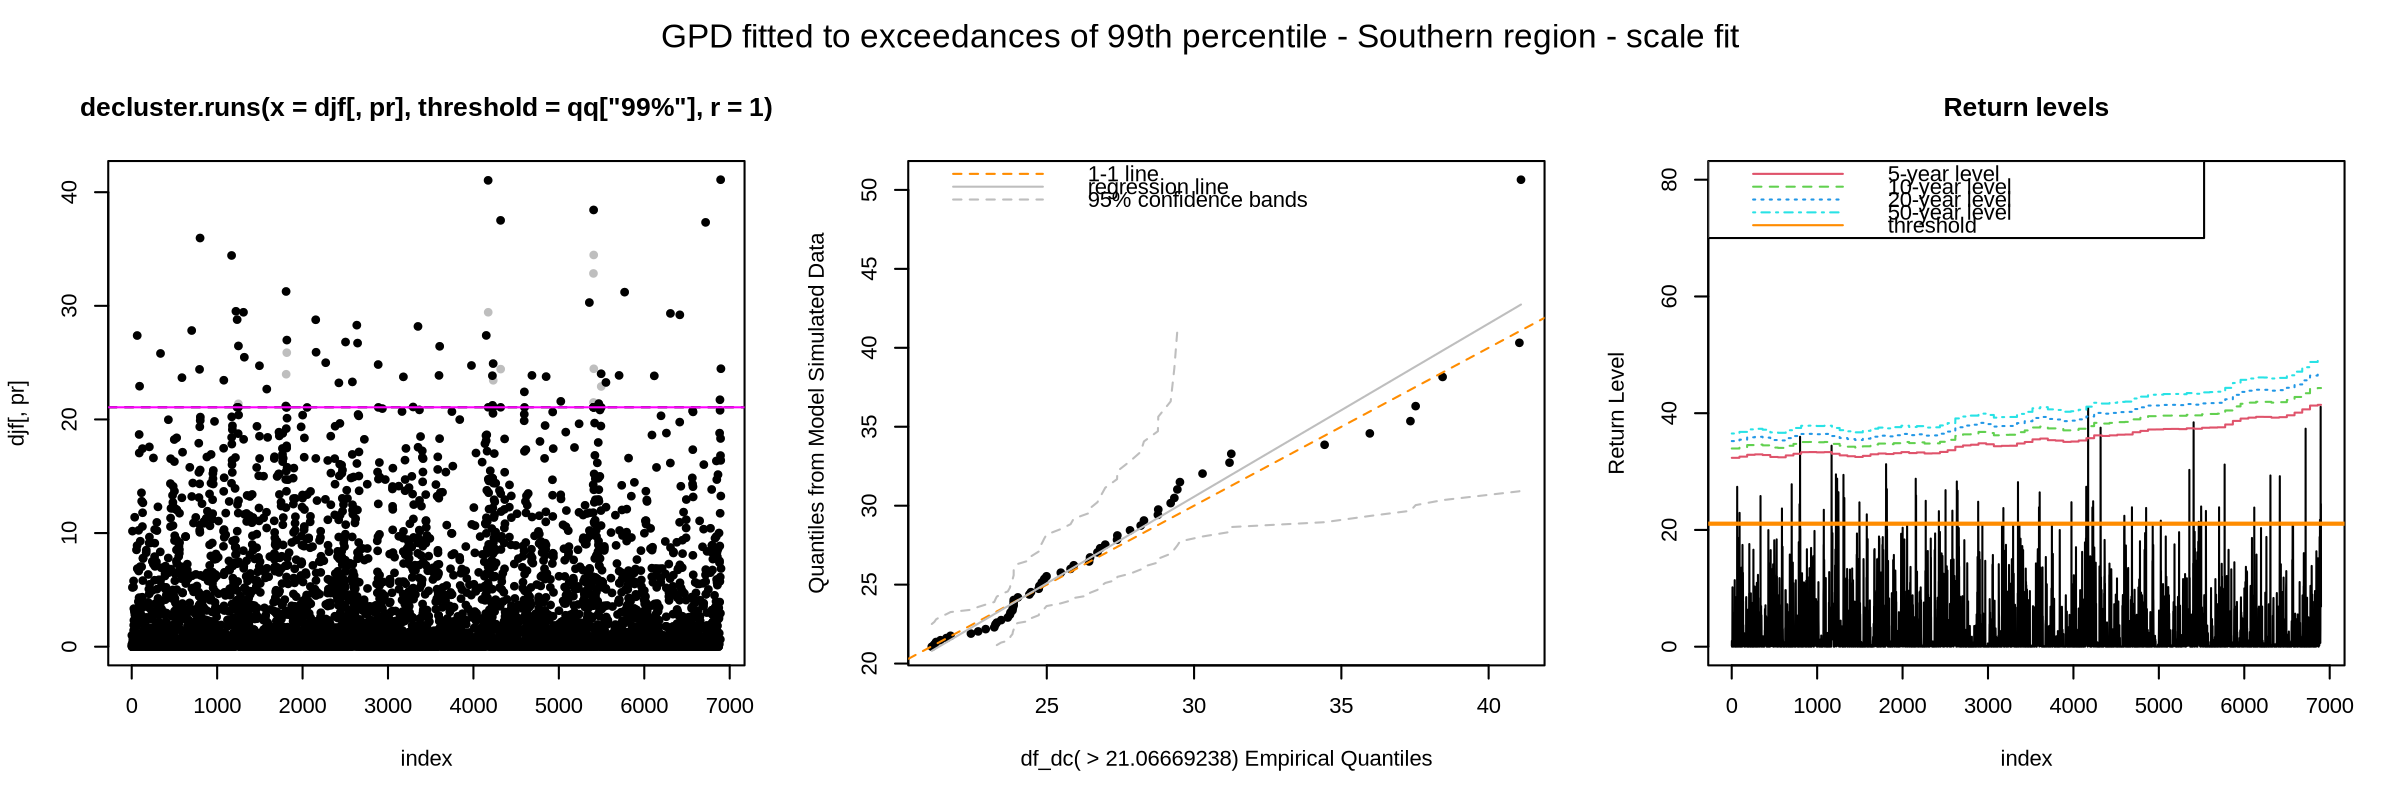

In [498]:
prep_window(c(1,3), oma = c(0,0,2,0))
plot(df_dc)
abline(h = qq["99%"], col = "magenta")
plot(mdl_gpd, type = "qq2", ylim = c(0,80), xlim = c(0,80))
plot(mdl_gpd, type = "rl", rperiods = c(5, 10, 20, 50), main = "Return levels", ylim = c(0,80))

mtext(paste0("GPD fitted to exceedances of 99th percentile - ",rnm, " - scale fit"), side = 3, outer = T)

## pdf of exceedances & fitted models

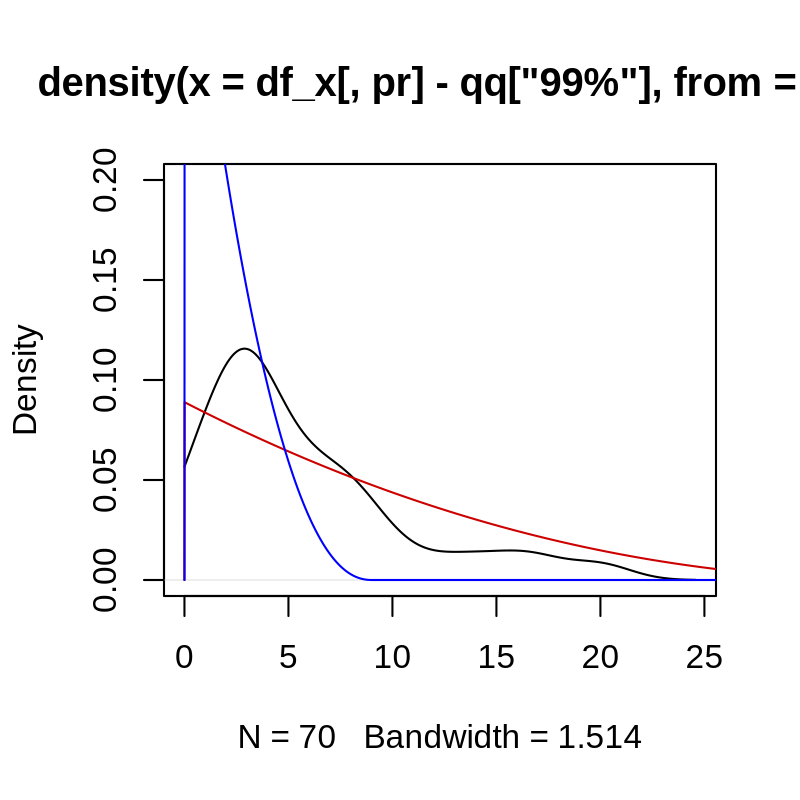

In [499]:
prep_window(c(1,1))

pars_gpd <- setNames(as.list(mdl_gpd$results$par), c("scale", "beta", "shape"))
pars_pp <- setNames(as.list(mdl_pp$results$par), c("loc", "alpha", "scale", "shape"))

plot(density(df_x[,pr] - qq["99%"], from = 0), ylim = c(0,0.2))
lines(x <- seq(0,40,0.01), do.call(devd, append(as.list(sapply(c("scale", "shape"), function(v) pars_gpd[[v]])), 
                                                 list(x = x, type = "GP"))), col = "red3")
lines(x <- seq(0,40,0.01), do.call(devd, append(as.list(sapply(c("scale", "shape"), function(v) pars_pp[[v]])), 
                                                 list(x = x, type = "GP"))), col = "blue")

In [519]:
pars = list("PP - shift" = pars_shift, "PP - shiftscale" = pars_shiftscale, "PP - scale" = pars_scale, "GPD - scale" = pars_gpd)

par_tbl <- rbind.fill(sapply(pars, function(l) data.frame(t(unlist(l))), simplify = F))
rownames(par_tbl) <- names(pars)

par_tbl

,loc,alpha,scale,shape,beta
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PP - shift,28.23077,0.06554192,5.577474,-0.2215478,NA
PP - shiftscale,30.26781,2.05159590,8.325978,-0.3254534,3.069199
PP - scale,28.12202,NA,8.092044,-0.3098692,2.800227
GPD - scale,NA,NA,11.245360,-0.3246449,3.667865


## Quantile regression

In [320]:
qq <- c(0.25,0.5,0.75,0.85,0.9,0.95,0.975,0.99, 0.995)
qr <- rq(paste0(pr, " ~ gmst"), data = djf, tau = qq)

qpred <- fitted(qr) #  get fitted quantiles

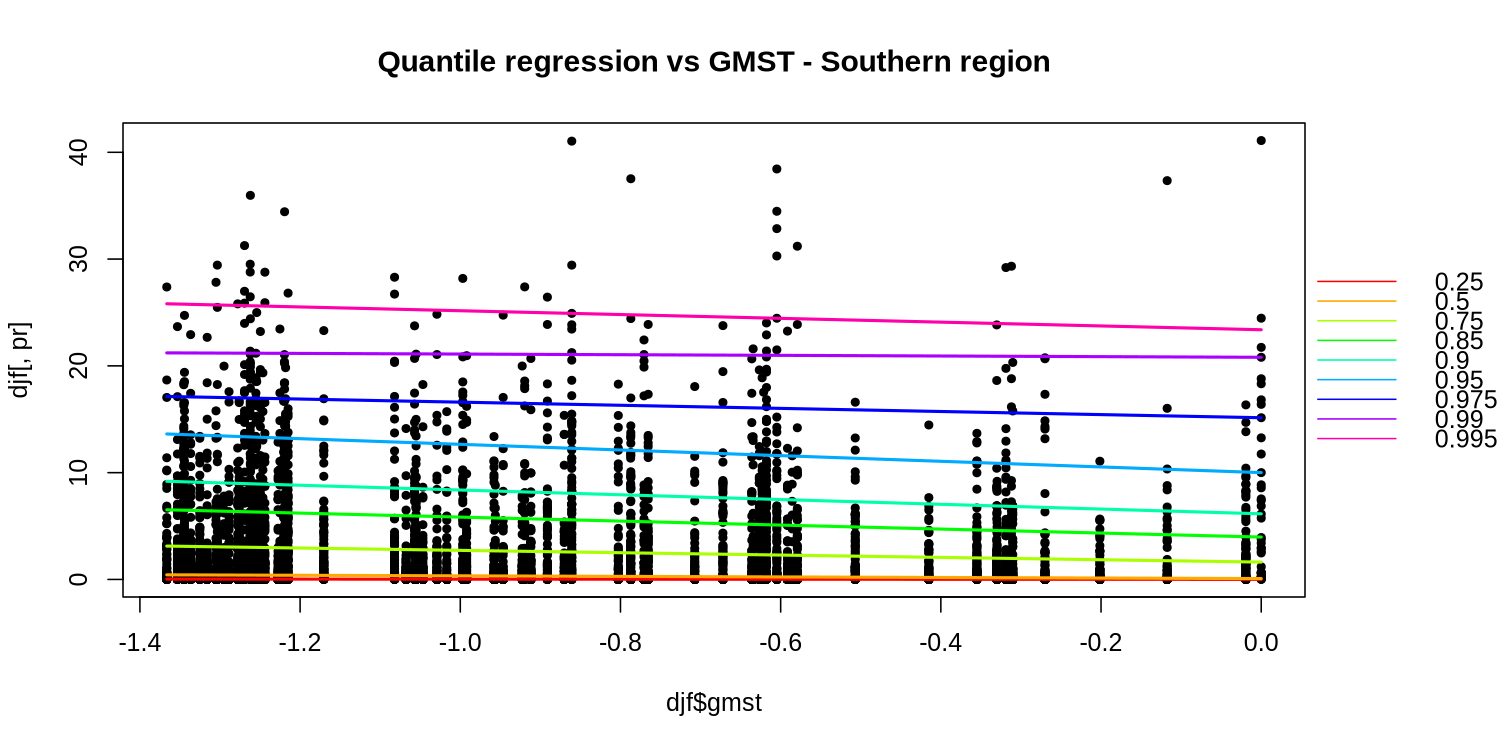

In [321]:
prep_window(xpd=TRUE, mar = c(5.1, 4.1, 4.1, 6.5), res = 150, h = 5, w = 10)
plot(djf$gmst, djf[,pr], main = paste0("Quantile regression vs GMST - ",rnm))
matplot(djf$gmst, qpred, add = T, type = "l", lty = 1, lwd = 2, col = rainbow(length(qq)))
legend("right", inset = c(-0.22, 0), legend = qq, lty = 1, col = rainbow(length(qq)), bty = "n")

In [322]:
coef(qr)

,tau= 0.250,tau= 0.500,tau= 0.750,tau= 0.850,tau= 0.900,tau= 0.950,tau= 0.975,tau= 0.990,tau= 0.995
(Intercept),0.008534021,0.08217695,1.625886,3.969625,6.146140,10.00465,15.144342,20.8025530,23.382326
gmst,-0.017513672,-0.25603042,-1.096728,-1.868258,-2.228954,-2.64768,-1.456963,-0.3030071,-1.779781
